In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
import math
import gzip

from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn.metrics import confusion_matrix
import sklearn

import cv2

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import KFold

from random import sample 

import seaborn as sns

# Image Classification - Fashion MNIST

Fashion MNIST section authored by: Phurushotham Shekar

Why Fashion MNIST?

    Mnist is super easy to learn and work on for Machine Learning models. Fashion Mnist adds a layer of complexity in its images with clothing and is therefore more challenging than Mnist.


Libraries used: 

    SKLearn: LDA, QDA, KFold, PCA
    
    Gzip: Open and parse the .gz files that the data are stored in
    
    CV: Used only to shrink the size of the image from 28x28 to 7x7
    
    
Steps:

    - First load in the datasets and store them as arrays
    
    - Preprocess data type 1: Then combine both training + test dataset and perform PCA on them to reduce dimensions
    
    - Preprocess data type 2: Shrink images from 28x28 to 7x7 using the cv resize library
    
    - Use Scikit learn to perform both PCA and QDA on the dataset
    
    - Cross Validate PCA and QDA using k-fold with k=6
    
    - Perform K-Nearest Neighbors algorithm with k = 3
    
    - Cross Validate K Nearest Neighbors with k-fold and k = 6
    
    - Determine best algorithm
    

In [2]:
#open and parse in the training images
f = gzip.open('../ml_proj/img/train-images-idx3-ubyte.gz','r')
num_images = 60000
image_size = 28
f.read(16)
buf = f.read(image_size * image_size * num_images)
#store as big_data and in size 6000x784
big_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
big_data = big_data.reshape(num_images, image_size*image_size)
print(big_data.shape)

(60000, 784)


In [3]:
#read and store label data for training images as labels
c = gzip.open('../ml_proj/img/train-labels-idx1-ubyte.gz','r')
c.read(8)
buf = c.read(num_images)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(labels.shape)

(60000,)


In [4]:
#do same as above but for testing data
td = gzip.open('../ml_proj/img/t10k-images-idx3-ubyte.gz','r')
num_test =10000
td.read(16)
buf = td.read(image_size * image_size * num_test)
data_test = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data_test = data_test.reshape(num_test, image_size* image_size)
print(data_test.shape)

(10000, 784)


In [5]:
#parse and store testing images
tl = gzip.open('../ml_proj/img/t10k-labels-idx1-ubyte.gz','r')
tl.read(8)
buf = tl.read(num_test)
label_test = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(label_test.shape)

(10000,)


# Feature Extraction using PCA and Resampling Image

Each sample has 784 features as it is a 28x28 image and each pixel is a feature. Since performing anything on so many features is very computationally expensive, we need to reduce the number of features that we perform calculations on. 

## PCA

As we did in Exercise 4, I performed PCA on the Fashion-Mnist dataset (instead of just 0's in the mnist as we did in the exercise). Principle Component Analysis (PCA) uses Singular Vector Decomposition to translate the 784 features we have into a lower dimension. Then, we pick the top percent of features that contain a certain percent of the energy (in our case 90%).

This PCA extraction was used to perform LDA and QDA on the dataset

In [6]:
#PCA
#combine both training + test data
all_data = np.append(big_data,data_test, axis=0)
#find mean
mean = (np.sum(all_data, axis=0))/70000
#center the data
data_centered = all_data - mean
#perform PCA
data_pca = skldecomp.PCA(n_components=0.96, svd_solver='full')
features_data = data_pca.fit_transform(data_centered)
#print number of features + shape
print(data_pca.n_components_)
print(features_data.shape)

226
(70000, 226)


In [7]:
#Since we'll be performing k-fold cross validation, we'll combine both our training + test data to a giant set of 70k samples, flatten it
#and then convert to numpy array in order to allow it to work with LDA and QDA functions
flat_train_data = np.asanyarray(features_data)
labels = np.append(labels,label_test)

## Resampling Image

For K-nearest neighbors I had originally tried using PCA. However, the output turned out to be 10% (literally guessing) so I figured there needed to bea nother method to extract features from the image. I decided that we could resample the image by taking squares of 4x4 and using the average value in this set of squares as the new pixel value in a 7x7 image. So every 4x4 grid of pixels in the original 28x28 size image corresponded to 1 pixel in our new 7x7 image. This reduced our number of features by approx. 94%!! 

We then used the resampled images to perform K nearest neighbors using the color value of each pixel to mean its "distance" in an axis. 

Here we first reshape our data to a 28x28 image. Then we shrink it and then re-flatten it.

In [8]:
#Resampling Image

all_data = all_data.reshape(70000,image_size,image_size)
image_data = []
for item in all_data:
    resized = cv2.resize(item,(7,7),interpolation = cv2.INTER_AREA)
    image_data.append(resized)

Below we show an example of what the original image looks like vs the now resampled image.

Original Image:


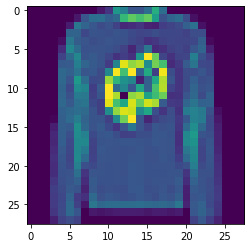

Resampled Image in 7x7:


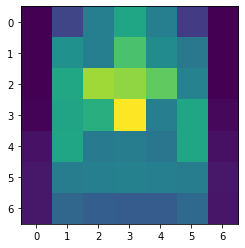

In [9]:
image_original = all_data[123] #332 because that is ECE major code
print("Original Image:")
plt.imshow(image_original)
plt.show()

image_shrunk = image_data[123]
print("Resampled Image in 7x7:")
plt.imshow(image_shrunk)
plt.show()

In [10]:
#KNN Preprocess data to put into KNN algorithm and K-fold validate
#by flattening it into 70000x49

flat_knn_data = [0]*70000
i=0
for item in image_data:
    flat_knn_data[i] = image_data[i].flatten()
    i +=1
    
use_knn_data = flat_knn_data[:6000]
use_knn_data = np.asanyarray(use_knn_data)
print("size:", use_knn_data.shape)

size: (6000, 49)


# LDA and QDA

As we learned in both lecture and Homework 4, LDA and QDA can be used for classification. Since here we have more than 2 classes, instead of comparing class 1 and class 2, we find the mean of all classes and then compare to the mean. LDA and QDA essentially create "regions" in which each class falls into. So when we test our new data point against all the regions using the two different formulas for LDA and QDA, they're both calculated slightly differently with different means, however we essentially select the region with the maximum likelihood of occurring. 

In [11]:
#LDA setup
lda_model = LDA()
lda_model.fit(flat_train_data,labels)
LDA()

#QDA setup
qda_model = QDA()
qda_model.fit(flat_train_data,labels)
QDA(priors=None, reg_param=0.0)

#KNN setup
knn_model = KNN()
knn_model.fit (flat_train_data,labels)
KNN(n_neighbors=100)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

# K nearest Neighbors (our k is 5)

The K nearest Neighbors algorithm calculates the euclidian distance between our data point and all of our test data points in p (number of features, in our case 49) dimensional space. It then finds the k (in our case 5) closest and then selects the class that appears the most often as the class for our data. 

My code for KNN that from scratch, calculates the above. And then also determined the % accuracy and returns it. 

Due to the computational complexity and runtime even with only 49 features, i only used 6000 samples instead of all 70000 samples

In [12]:
#Code for KNN
def knn(Xtrain,Xtest,Ytrain,Ytest):

    Xtrain = np.asanyarray(Xtrain)
    Xtest = np.asanyarray(Xtest)
    Ytrain = np.asanyarray(Ytrain)
    Ytest = np.asanyarray(Ytest)
    
    k = 100
    test_sample = Ytest.size
    output = [-1]*test_sample
    
    counter=0
    for sample in range(test_sample):
        dist = {}
        i=0
        for obj in Xtrain:
            dist[i] = np.linalg.norm(Xtest[sample]-obj)
            i += 1

        neighbors = sorted(dist, key=dist.get)[:int(k)]
        result = []
        for j in range(len(neighbors)):
            result.append(Ytrain[neighbors[j]])

        answer = max(set(result), key=result.count)
        output[counter] = answer
        counter +=1
    
    output = np.asanyarray(output)
    return output


# K-Fold Validation

The way Kfold validation works is by splitting all of our samples into k sections randomly. Then we take turns selecting each of the k sections as our "test" data and treating the rest as our training data. So, we run each function k times and take the average of all the accuracies. Whichever method is most accurate amongst all splits is our "winner".

We perform K-fold validation here for both LDA and QDA, calculate their scores and then find the mean of each score

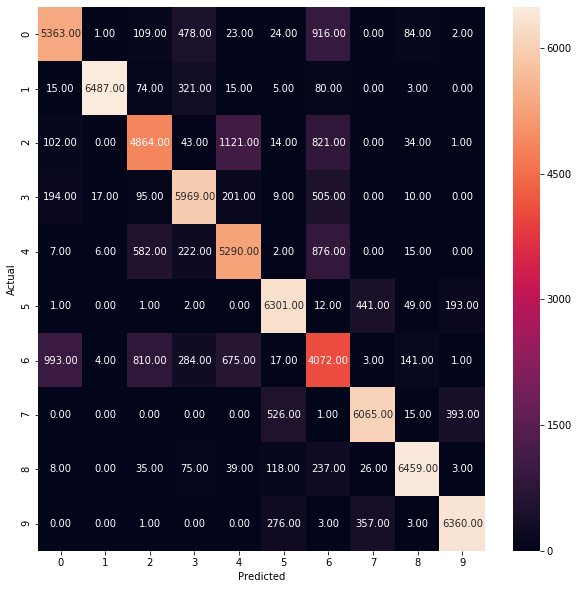

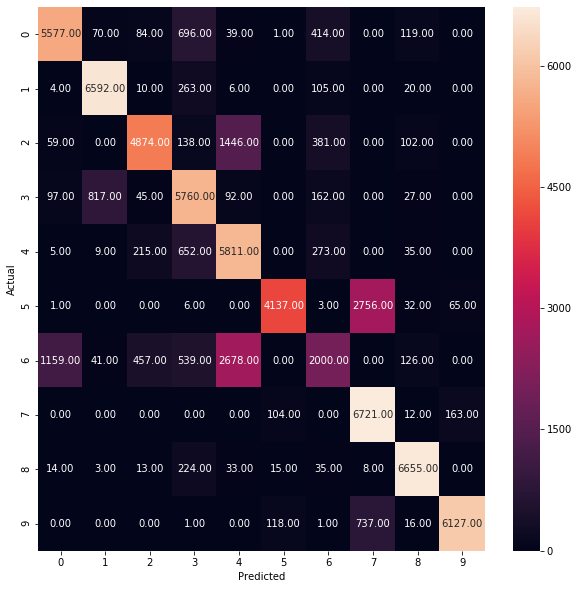

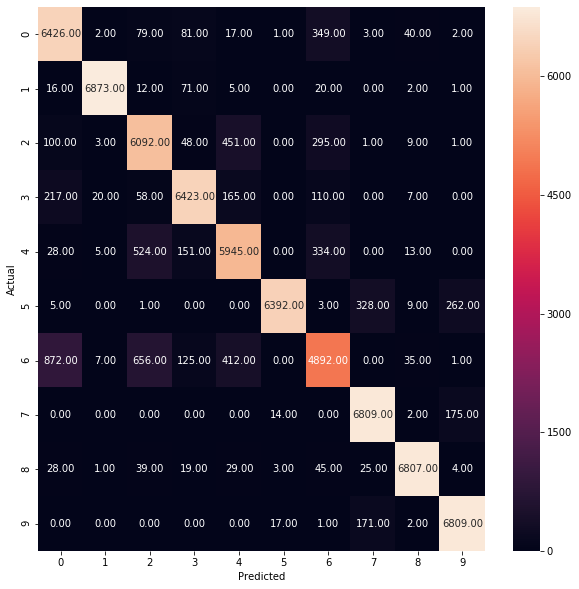

In [13]:
#arrays to store scores
scoresLDA = []
scoresQDA = []
scoresKNN = []
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
numsplits = 6

#create our Kfold validation object
validate= KFold(n_splits=numsplits, shuffle=True)

#Kfold validation code for LDA
for train_index, test_index in validate.split(flat_train_data):
    X_train, X_test = flat_train_data[train_index], flat_train_data[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
    lda_model.fit(X_train, Y_train)
    y_pred = lda_model.predict(X_test)
    scoresLDA.append(confusion_matrix(Y_test, y_pred))


conf_matrLDA = np.add(scoresLDA[0],np.add(scoresLDA[1],np.add(scoresLDA[2],np.add(scoresLDA[3],np.add(scoresLDA[4],scoresLDA[5])))))

# Normalise
cmn = conf_matrLDA.astype('float') 
conf_matrLDA.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#Kfold validation code for QDA
for train_index, test_index in validate.split(flat_train_data):
    X_train, X_test = flat_train_data[train_index], flat_train_data[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
    y_pred = qda_model.predict(X_test)
    scoresQDA.append(confusion_matrix(Y_test, y_pred))
    
conf_matrQDA = np.add(scoresQDA[0],np.add(scoresQDA[1],np.add(scoresQDA[2],np.add(scoresQDA[3],np.add(scoresQDA[4],scoresQDA[5])))))
# Normalise
cmn = conf_matrQDA.astype('float') 
conf_matrQDA.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Kfold validation code for KNN
for train_index, test_index in validate.split(flat_train_data):
    X_train, X_test = flat_train_data[train_index], flat_train_data[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
    #y_pred = knn(X_train,X_test,Y_train,Y_test)
    y_pred = knn_model.predict(X_test)
    #y_pred = np.asanyarray(y_pred)
    scoresKNN.append(confusion_matrix(Y_test, y_pred))
    
conf_matrKNN = np.add(scoresKNN[0],np.add(scoresKNN[1],np.add(scoresKNN[2],np.add(scoresKNN[3],np.add(scoresKNN[4],scoresKNN[5])))))
# Normalise
cmn = conf_matrKNN.astype('float') 
conf_matrKNN.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## The code below displays all of the scores for our 3 methods

## The Code Below determines mean accuracy among all folds for each of our 3 methods and then prints it. 

I recommend the one with the greatest mean